Code adapted and modified from https://github.com/blei-lab/variational-smc.

In [1]:
using Random, LinearAlgebra, Distributions, Plots
using AutoGrad

In [2]:
mutable struct SMC
    T::Integer     # Length of sequence
    dimX::Integer  # Dimension of latent variables
    dimY::Integer  # Dimension of observations
    N::Integer     # Number of particles
    
    sim_prop    # Function for sampling from proposal
    log_weights # Function for computing weights
end

In [90]:
function rho(i,∇obj,prev_s;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇obj)^2+(1-t)*prev_s
    ρ = η*i^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s, ρ
end

function gradient_descent(obj_f, grad_f, opt_params; iters=100, step="rho")
    dim_params = length(opt_params)
    params = zeros(iters,dim_params)
    objs = zeros(iters)
    
    params[1,:] .= opt_params
    objs[1] = obj_f(opt_params)
    
    if step == "rho"
        ss = ones(iters,dim_params)
    end
    
    for i in 1:iters-1
        ∇obj = grad_f(params[i,:])
        for j in 1:dim_params
            if step == "rho"
                s, ρ = rho(i,∇obj[j],ss[i])
                ss[i+1,j] = s
                params[i+1,j] = params[i,j] + ρ*∇obj[j]
            end
        end
        objs[i+1] = obj_f(params[i+1,:])
    end
    return params, objs
end

gradient_descent (generic function with 1 method)

In [43]:
function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = 0
    P_filt = 0
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + log(2*π))
    end
    return log_likelihood
end

function log_normal(x,μ,Σ)
    dim = size(x)[2]
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    prec = inv(Σ) # AutoGrad doesn't support backslash
    return log_norm .- 0.5*diag(diff*prec*diff') # Original code does sum here but that seems incorrect
end

function log_target(t, X, X_anc, y, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    log_trans = log_normal(X,(A*X_anc')',Q)
    #if t > 1
    #    log_trans = log_normal(X,(A*X_anc')',Q)
    #else
    #    log_trans = log_normal(X,μ0,Σ0)
    #end
    log_obs = log_normal((C*X')',y[t],R)
    return log_trans + log_obs
end

log_target (generic function with 1 method)

In [308]:
function categorical_resample(W)
    dist = Categorical(W[:,1])
    return rand(dist,N)
end
@zerograd categorical_resample(W)

function gumbelsoftmax_resample(W,X,τ)
    N = size(W)[1]
    g = -log.(-log.(rand(N,N)))
    mix_prop = exp.((log.(W') .+ g) ./ τ)
    mix_prop = mix_prop ./ sum(mix_prop, dims=2)
    return mix_prop * X
end

function invertgaussian_resample(W,X,τ;δ=0.1)
    N = size(W)[1]
    σ = sqrt(sum((W .- mean(W)).^2))
    w = W[1:N-1]' .+ σ.*randn(N,N-1)
    
    # Logistic
    w = 1 .- (1 ./ (1 .+ exp.(-w)))
    # Stick-breaking
    for i in N .- (1:N-1)
        if i > 1
            w[:,i] = (1 .- w[:,i]) .* prod(w[:,1:i-1], dims=2)
        else
            w[:,i] = (1 .- w[:,i])
        end
    end
    # Softmax
    mix_prop = exp.(w./τ)
    mix_prop = mix_prop ./ (sum(mix_prop, dims=2) .+ δ)
    mix_prop = [mix_prop (1 .- sum(mix_prop, dims=2))]
    println(mix_prop)
    println(sum(mix_prop,dims=2))
    return mix_prop * X
end

function vsmc_lower_bound(prop_params, model_params, y, smc; method="categorical", τ=0.1, verbose=false)
    # Extract constants
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    X_anc = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) / N
    logZ = 0
    
    for t in 1:T
        # Resample
        if t > 1
            if method == "gumbelsoftmax"
                X_anc = gumbelsoftmax_resample(W,X,τ)
            elseif method == "invertgaussian"
                X_anc = invertgaussian_resample(W,X,τ)
            else
                anc = categorical_resample(W)
                X_anc = X[anc,:]
            end
        end
        
        # Propose
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        # Reweight
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        logZ = logZ + max_logW + log(sum(W)) - log(N)
        W /= sum(W)
    end
    if verbose
        ESS = (1/sum(W.^2)) / N # Effective sample size divided by N
        println("ESS: ", ESS)
    end
    return logZ
end

function ∇vsmc_lower_bound(prop_params, model_params, y, smc; verbose=false)
    # Extract constants
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N,dimX)
    X_anc = zeros(N,dimX)
    logW = zeros(N)
    W = exp.(logW) / N
    logZs = zeros(T)
    anc = 1:N
    
    prev_∇log_W = zeros(N)
    gweights = zeros(T-1)
    grep = 0
    
    ∇ϕ = 0
    
    for t in 1:T
        # Resample
        if t > 1
            anc = categorical_resample(W)
            X_anc = X[anc,:]
        end
        
        # Propose
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        function log_prop_closure(prop_params,i)
            return SLGSS_log_prop(X, X_anc, prop_params)[i]
        end
        ∇log_prop = grad(log_prop_closure)
        for i in 1:N
            ∇ϕ += ∇log_prop(prop_params,i)[1] + prev_∇log_W[anc[i]]
        end
        
        # Reweight
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        if t > 1
            logZs[t] = logZs[t-1] + max_logW + log(sum(W)) - log(N)
        else
            logZs[t] = max_logW + log(sum(W)) - log(N)
        end
        W /= sum(W)
        
        function log_weights_closure(prop_params,i)
            return smc.log_weights(t,X,X_anc,y,prop_params,model_params)[i]
        end
        ∇log_weights = grad(log_weights_closure)
        
        for i in 1:N
            prev_∇log_W[i] = ∇log_weights(prop_params,i)[1]
            grep += W[i] * prev_∇log_W[i]
        end
        
        if t < T
            ∇ϕ -= N*(W' * prev_∇log_W)
        end
    end
    g_score = logZs[T]*∇ϕ
    return grep + g_score
end

∇vsmc_lower_bound (generic function with 1 method)

In [309]:
invertgaussian_resample([0.3,0.2,0.5],[0,5,10],0.1)

[0.9492728191938961 0.050313917425062984 0.0004132633810409736; 0.9702081028759301 0.02948918757652362 0.0003027095475462982; 0.8061968898226248 0.19296173601891922 0.0008413741584559764]
[1.0; 1.0; 1.0]


3-element Array{Float64,1}:
 0.25570222093572464
 0.1504730333580811
 0.9732224216791558

# Scalar linear Gaussian state space model

In [197]:
function SLGSS_init_model_params()
    μ0 = 0
    Σ0 = 1
    A = 0.5
    Q = 1
    C = 1
    R = 1
    return μ0, Σ0, A, Q, C, R
end

function SLGSS_generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    
    for t in 1:T
        if t > 1
            x_dist = Normal(A*x_true[t-1],Q)
        else
            x_dist = Normal(0,Q)
        end
        x_true[t] = rand(x_dist,1)[1]
        y_dist = Normal(C*x_true[t],R)
        y_true[t] = rand(y_dist,1)[1]
    end
    return x_true, y_true
end

function SLGSS_log_prop(X, X_anc, prop_params)
    λ = prop_params
    μ = λ .+ 0.5*X_anc
    return log_normal(X,μ,1)
end

function SLGSS_log_weights(t, X, X_anc, y, prop_params, model_params)
    return log_target(t,X,X_anc,y,model_params) - SLGSS_log_prop(X,X_anc,prop_params)
end

function SLGSS_sim_prop(t, X_anc, y, prop_params, model_params)
    λ = prop_params
    N = size(X_anc)[1]
    μ = λ .+ 0.5*X_anc
    return μ + randn(N)
end

function estimate_var(λs, grad_f; samples=100)
    ∇_means = zeros(length(λs))
    ∇_vars = zeros(length(λs))
    for i in 1:length(λs)
        λ = λs[i]
        ∇λ = zeros(samples)
        for j in 1:samples
            ∇λ[j] = grad_f(λ)
        end
        ∇_means[i] = mean(∇λ)
        ∇_vars[i] = var(∇λ)
    end
    return ∇_means, ∇_vars
end

estimate_var (generic function with 1 method)

x: [-0.9689681602139302, -0.9338172598574561]
y: [0.15739250051167475, 0.1123442849447478]
True log-marginal likelihood: -2.568783408116662
λ0: 0.3781520148769962
λ*: 0.11602663308997638
ESS: 0.931998002048438
Final VSMC bound: -2.7277140143826824


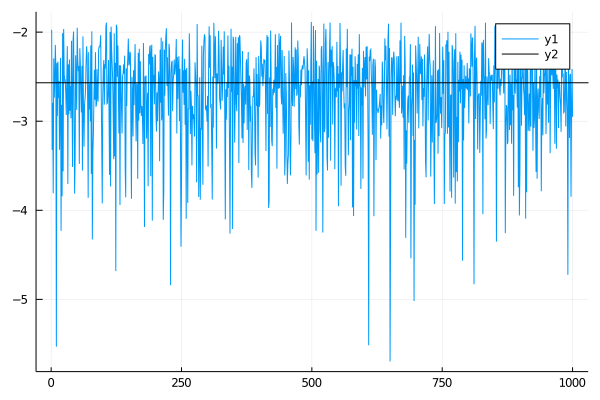

In [210]:
T = 2
N = 2

slgss_smc = SMC(T,1,1,N,SLGSS_sim_prop,SLGSS_log_weights)

# Initialize model params
model_params = SLGSS_init_model_params()

# Generate data
x_true, y_true = SLGSS_generate_data(model_params, T)
println("x: ", x_true)
println("y: ", y_true)

# True log marginal likelihood via Kalman filter
log_marginal = log_marginal_likelihood(model_params, T, y_true)
println("True log-marginal likelihood: ", log_marginal)

# Initialize variational params
λ = randn(1)[1]
println("λ0: ", λ)

function SLGSS_obj(λ; verbose=false)
    #return vsmc_lower_bound(λ,model_params,y_true,slgss_smc,verbose=verbose)[1]
    return vsmc_lower_bound(λ,model_params,y_true,slgss_smc,method="gumbelsoftmax",τ=0.1,verbose=verbose)[1]
end
function ∇SLGSS_obj(λ)
    grad_f = grad(SLGSS_obj)
    ∇λ = grad_f(λ)[1]
    #∇λ = ∇vsmc_lower_bound(λ,model_params,y_true,slgss_smc)
    return ∇λ
end
iters = 1000

λs, vsmcb = gradient_descent(SLGSS_obj, ∇SLGSS_obj, λ, iters=iters)

println("λ*: ",λs[iters])
println("Final VSMC bound: ", SLGSS_obj(λs[iters],verbose=true))
plot(1:iters,vsmcb)
hline!([log_marginal],linecolor=:black)

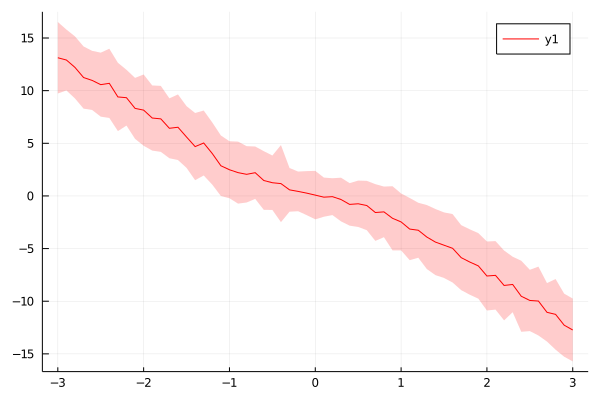

In [211]:
xs = -3:0.1:3

∇_means, ∇_vars = estimate_var(xs, ∇SLGSS_obj, samples=100)
∇_stds = sqrt.(∇_vars)
plot(xs, ∇_means, ribbon=∇_stds, linecolor="red", fillcolor="red", fillalpha=0.2)

# Linear Gaussian state space model

In [9]:
function init_model_params(dimX, dimY, α, r, obs)
    μ0 = zeros(dimX)
    Σ0 = Matrix{Float64}(I,dimX,dimX)
    
    A = zeros(dimX,dimX)
    for i in 1:dimX
        for j in 1:dimX
            A[i,j] = α^(abs(i-j)+1)
        end
    end
    
    Q = Matrix{Float64}(I,dimX,dimX)
    
    # TODO: obs
    # C = zeros(dimY,dimX)
    C = randn(dimY,dimX)
    
    R = r*Matrix{Float64}(I,dimY,dimY)
    
    return μ0, Σ0, A, Q, C, R
end

function init_prop_params(T, dimX, scale)
    return [(scale*randn(dimX), # Bias
            1 .+ scale*randn(dimX), # Linear times A/μ0
            scale*randn(dimX)) # Log-var
            for t in 1:T]
end

function generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    x_true = zeros(T,dimX)
    y_true = zeros(T,dimY)
    
    for t in 1:T
        if t > 1
            x_dist = MvNormal(A*x_true[t-1,:],Q)
        else
            x_dist = MvNormal(μ0,Σ0)
        end
        x_true[t,:] = rand(x_dist,1)
        
        y_dist = MvNormal(C*x_true[t,:],R)
        y_true[t,:] = rand(y_dist,1)
    end
    
    return x_true, y_true
end

function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = zeros(dimX)
    P_filt = zeros(dimX,dimX)
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t,:] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        # TODO: double check this correct
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + dimY*log(2*π))
    end
    return log_likelihood
end

function sim_prop(t, X_anc, y, prop_params, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σt = sqrt.(exp.(log_σ2t))
    
    N, dimX = size(X_anc)
    
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = (μt + lint.*μ0)'
    end
    return μ .+ randn(N,dimX) .* σt'
end

function log_normal(x,μ,Σ)
    dim = size(Σ)[1]
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    prec = inv(Σ) # AutoGrad doesn't support backslash
    return log_norm .- 0.5*diag(diff*prec*diff') # Original code does sum here but that seems incorrect
end

function log_target(t, X, X_anc, y, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    if t > 1
        logF = log_normal(X,(A*X_anc')',Q)
    else
        logF = log_normal(X,μ0,Σ0)
    end
    logG = log_normal((C*X')',y[t],R)
    return logF + logG
end

function log_prop(t,X,X_anc,y,prop_params,model_params)
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σ2t = exp.(log_σ2t)
    dimX = length(σ2t)
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = μt + lint.*μ0
    end
    return log_normal(X,μ,Matrix{Float64}(I,dimX,dimX).*σ2t)#Matrix{Float64}(I,dimX,dimX) .* σ2t)
end

function log_weights(t, X, X_anc, y, prop_params, model_params)
    return log_target(t,X,X_anc,y,model_params) - log_prop(t,X,X_anc,y,prop_params,model_params)
end

log_weights (generic function with 1 method)

In [10]:
# Model hyperparameters
T = 10
dimX = 10
dimY = 3
α = 0.42
r = 1 #0.1
obs = "sparse"

# Training parameters
param_scale = 0.5
num_epochs = 1000
step_size = 0.001

N = 4

model_params = init_model_params(dimX, dimY, α, r, obs)

x_true, y_true = generate_data(model_params, T)
# println("True x: ", x_true)
# println("True y: ", y_true)

log_marginal = log_marginal_likelihood(model_params, T, y_true)
println("True log-marginal likelihood: ", log_marginal)

prop_params = init_prop_params(T, dimX, param_scale)

lgss_smc_obj = SMC(T,dimX,dimY,N,sim_prop,log_weights)

println("VSMC lower bound: ",vsmc_lower_bound(prop_params, model_params, y_true, lgss_smc_obj))

function rho(iter,∇L,ss;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*iter^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

function flatten_prop_params(prop_params)
    T = length(prop_params)
    dimX = length(prop_params[1][1])
    dimλ = 3*T*dimX
    flat_params = zeros(dimλ)
    k = 3*dimX
    for i in 1:T
        flat_params[(1+k*(i-1)):(k+k*(i-1))] .= (prop_params[i][1]...,prop_params[i][2]...,prop_params[i][3]...)
    end
    return flat_params, dimλ
end

function reshape_flat_params(flat_params, prop_params)
    T = length(prop_params)
    dimX = length(prop_params[1][1])
    k = 3*dimX
    return [(flat_params[(1+k*(i-1)):(dimX+k*(i-1))],
             flat_params[(1+dimX+k*(i-1)):(2*dimX+k*(i-1))],
             flat_params[(1+2*dimX+k*(i-1)):(k+k*(i-1))]) for i in 1:T]
end


function objective(flat_params,prop_params)
    reshaped_params = reshape_flat_params(flat_params,prop_params)
    return vsmc_lower_bound(reshaped_params, model_params, y_true, lgss_smc_obj)
end

flat_params, dimλ = flatten_prop_params(prop_params)

True log-marginal likelihood: -70.86903844656914


LoadError: [91mUndefVarError: LGSS_SMC not defined[39m

In [11]:
iters = 500
λs = zeros(iters,dimλ)
λs[1,:] = flat_params
vsmcb = zeros(iters)
vsmcb[1] = vsmc_lower_bound(prop_params,model_params,y_true,lgss_smc_obj)
ss = ones(iters,dimλ)
#ρs = zeros(iters)

∇objective = grad(objective)
for i in 1:iters-1
    ∇λ = ∇objective(λs[i,:],prop_params) #ForwardDiff.gradient(λ->objective(λ,prop_params),λs[i,:])
    for j in 1:dimλ
        s,ρ = rho(i,∇λ[j],ss[i,j])
        ss[i+1,j] = s
        λs[i+1,j] = λs[i,j] + ρ*∇λ[j]
    end
    vsmcb[i+1] = vsmc_lower_bound(reshape_flat_params(λs[i+1,:],prop_params),model_params,y_true,lgss_smc_obj)
end
final_params = reshape_flat_params(λs[iters,:],prop_params)
println("VSMC bound: ", vsmc_lower_bound(final_params,model_params,y_true,lgss_smc_obj))
plot(1:iters,vsmcb)
hline!([log_marginal], linecolor=:black)

LoadError: [91mUndefVarError: dimλ not defined[39m

In [12]:
using HTTP: request

"https://gist.githubusercontent.com/vankesteren/96207abcd16ecd01a2491bcbec12c73f/raw/1b59af6962a1107db5873eba59054acc3f9a8aac/Adamopt.jl" |>
  url -> request("GET", url) |> 
  res -> String(res.body) |> 
  str -> include_string(Main, str)

using .Adamopt


iters_adam = 500
loss = λ -> -vsmc_lower_bound(reshape_flat_params(λ,prop_params),model_params,y_true,lgss_smc_obj)
grad = λ -> -ForwardDiff.gradient(λ->objective(λ,prop_params),λ)
dopt = Adam(flat_params,loss,grad)
dopt.a = 0.01
vsmc_adam = zeros(iters_adam)
for i = 1:iters_adam
    step!(dopt)
    vsmc_adam[i] = -dopt.loss(dopt.theta)
    #print(string("Step: ", dopt.t, " | Loss: ", dopt.loss(dopt.theta), "\n"))
end
final_adam_params = reshape_flat_params(dopt.theta,prop_params)
println("VSMC bound: ", vsmc_lower_bound(final_adam_params,model_params,y_true,lgss_smc_obj))
plot(1:iters_adam,vsmc_adam)
hline!([log_marginal], linecolor=:black)

LoadError: [91mUndefVarError: flat_params not defined[39m